# Transfer learning for NLP
## ALTEGRAD - Lab session 3
#### Moussa Kamal Eddine, Hadi Abdine (Dascim LIX)
##### November 2020

# Nouvelle section

In [ ]:
import math

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### The Model

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        '''
        ntokens: the size of vocabulary
        nhid: the hidden dimension of the model.
        We assume that embedding_dim = nhid
        nlayers: the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        nhead: the number of heads in the multiheadattention models
        dropout: the dropout value
         '''
        self.model_type = "Transformer"
        self.encoder = nn.Embedding(ntokens,nhid) # fill me, nhid = the dim_embed
        self.pos_encoder = PositionalEncoding(nhid, dropout) #fill me, the PositionalEncoding class is implemented in the next cell
        encoder_layers = nn.TransformerEncoderLayer(nhid,nhead,nhid,dropout) #fill me we assume nhid = d_model = dim_feedforward
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers,nlayers) #fill me
        self.nhid = nhid
        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):
        src = self.encoder(src) * math.sqrt(self.nhid) 
        src = self.pos_encoder( src )
        output = self.transformer_encoder(src, src_mask)
        return output


class ClassificationHead(nn.Module):
    def __init__(self, nhid, nclasses):
        super(ClassificationHead, self).__init__()
        self.decoder = nn.Linear( nhid, nclasses )
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        output = self.decoder(src)
        return output
    
class Model(nn.Module):
    def __init__(self, ntoken, nhead, nhid, nlayers, nclasses, dropout=0.5):
        super(Model, self).__init__()
        self.base = TransformerModel( ntoken, nhead, nhid, nlayers, dropout)
        self.classifier = ClassificationHead( nhid, nclasses)

    def forward(self, src, src_mask):
        # base model
        x = self.base( src, src_mask )
        # classifier model
        output = self.classifier( x )
        return output

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, nhid, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, nhid)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, nhid, 2).float() * (-math.log(10000.0) / nhid)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

Let's verify if our model works, by applying one inference step

In [ ]:
ntokens = 100 #fill me # the size of vocabulary
nhid = 200  # hidden dimension
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)
dummy_input = torch.tensor([[2, 6, 2, 5, 43, 21]]).to(device)
src_mask = model.base.generate_square_subsequent_mask(1).to(device)
out = model.forward(dummy_input, src_mask)

print(out.shape) # is it the right shape?

torch.Size([1, 6, 100])


## Vocabulary and Tokenization

In [ ]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
!head -5 dict.txt

--2020-12-08 20:53:24--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/dict.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 577587 (564K) [text/plain]
Saving to: ‘dict.txt.2’

dict.txt.2          100%[===================>] 564.05K  --.-KB/s    in 0.03s   

2020-12-08 20:53:24 (17.0 MB/s) - ‘dict.txt.2’ saved [577587/577587]

▁d 1
es 1
▁l 1
en 1
on 1


In [ ]:
path_vocab = "dict.txt"
token2ind = {"<sos>": 0, "<pad>": 1, "<eos>": 2, "<oov>": 3} # the 4 first indices are reserved to special tokens
with open(path_vocab, "r") as f:
    for idx, line in enumerate(f):
        word = line.split()[0].strip()
        token2ind[word] =   idx + 4

ind2token =  { value: key for key, value in token2ind.items() }

print(ind2token[1111])

▁trop


### Data Loader


In [ ]:
import numpy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset


class Dataset(Dataset):
    def __init__(
        self,
        path_documents,
        path_labels=None,
        token2ind={},
        max_len=512,
        task="language_modeling",
    ):
        self.task = task
        self.max_len = max_len
        self.token2ind = token2ind
        self.documents = []
        self.labels = []
        with open(path_documents, "r") as f1:
            for line in f1:
                self.documents.append(line.strip())
        if task == "classification":
            with open(path_labels, "r") as f1:
                for line in f1:
                    self.labels.append(int(line.strip()))
            assert len(self.labels) == len(self.documents)

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, index):
        sequence = self.documents[index].split()
        if len(sequence) > self.max_len - 1:
            sequence = sequence[: self.max_len - 1]
        source_sequence = [self.token2ind["<sos>"]] + [
            self.token2ind[word] if word in self.token2ind else self.token2ind["<oov>"]
            for word in sequence[: self.max_len]
        ]
        if self.task == "language_modeling":
            target = source_sequence[1:]
            target.append(self.token2ind["<eos>"])
        elif self.task == "classification":
            target = [self.labels[index]]
        sample = {
            "source_sequence": torch.tensor(source_sequence),
            "target": torch.tensor(target),
        }
        return sample


def MyCollator(batch):
    source_sequences = pad_sequence(
        #we use padding to match the length of the sequences in the same batch
        [sample["source_sequence"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    target = pad_sequence(
        [sample["target"] for sample in batch], padding_value=token2ind["<pad>"]
    )
    return source_sequences, target.reshape(-1)


def get_loader(
    path_documents,
    path_labels=None,
    token2ind={},
    max_len=512,
    batch_size=32,
    task="language_modeling",
):
    dataset = Dataset(
        path_documents,
        path_labels=path_labels,
        token2ind=token2ind,
        max_len=512,
        task=task,
    )
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=MyCollator,
        pin_memory=True,
        drop_last=True,
    )
    return data_loader

## The Training

In [ ]:
def train(
    path_data_train,
    path_labels_train=None,
    path_data_valid=None,
    save_interval=-1,
    log_interval=5,
    task="language_modeling",
    batch_size=32,
):
    model.train()
    total_loss = 0.0
    ntokens = len(token2ind)
    data_loader = get_loader(
        path_data_train,
        path_labels_train,
        token2ind,
        task=task,
        batch_size=batch_size,
    )
    
    losses = []
    for idx, data in enumerate(data_loader): #step 1
        optimizer.zero_grad()
        src_mask = model.base.generate_square_subsequent_mask(data[0].size(0)).to(
            device
        )
        input = data[0].to(device)
        output = model(input, src_mask) #step 2
        if task == 'classification':
            #last vector only
            output = output[-1,:] 
        output = output.view(-1, output.shape[-1])
        target =  data[1]
        target = target.to(device)
        loss =  criterion(output, target)#fill me, Cross entropy check next cells
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # prevent exploding gradient 
        optimizer.step()

        total_loss += loss.item() 
        if idx % log_interval == 0 and idx > 0:
            cur_loss = total_loss / log_interval
            print(
                "| epoch {:3d} | {:5d}/{:5d} steps | "
                "loss {:5.5f} | ppl {:8.3f}".format(
                    epoch, idx, len(data_loader), cur_loss, math.exp(cur_loss),
                )
            )
            losses.append(cur_loss)
            total_loss = 0
    return losses

In [ ]:
ntokens = len(ind2token) #fill me # the size of vocabulary
nhid = 200  # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4  # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # the number of heads in the multiheadattention models
dropout = 0  # the dropout value

nclasses = 2 # for classification task only

model = Model(ntokens, nhead, nhid, nlayers, ntokens, dropout).to(device)

In [ ]:
# optimization paramerters

criterion = nn.CrossEntropyLoss(ignore_index=token2ind['<pad>'])
lr = 0.0003  # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
path_data_train = "pretraining_subset.txt"

--2020-12-08 20:53:58--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretraining_subset.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10146460 (9.7M) [text/plain]
Saving to: ‘pretraining_subset.txt’

pretraining_subset. 100%[===================>]   9.68M  --.-KB/s    in 0.1s    

2020-12-08 20:53:58 (79.9 MB/s) - ‘pretraining_subset.txt’ saved [10146460/10146460]



In [ ]:
#pretraining on a tiny subset
log_interval = 500
epochs = 5
for epoch in range(1, epochs + 1): #5
    train(
        path_data_train,
        save_interval=-1,
        task="language_modeling",
        batch_size=16,
        log_interval=log_interval
    )

| epoch   1 |   500/ 3125 steps | loss 7.30127 | ppl 1482.182
| epoch   1 |  1000/ 3125 steps | loss 6.51861 | ppl  677.635
| epoch   1 |  1500/ 3125 steps | loss 6.24379 | ppl  514.807
| epoch   1 |  2000/ 3125 steps | loss 6.03679 | ppl  418.549
| epoch   1 |  2500/ 3125 steps | loss 5.92552 | ppl  374.472
| epoch   1 |  3000/ 3125 steps | loss 5.80861 | ppl  333.156
| epoch   2 |   500/ 3125 steps | loss 5.52053 | ppl  249.767
| epoch   2 |  1000/ 3125 steps | loss 5.47245 | ppl  238.042
| epoch   2 |  1500/ 3125 steps | loss 5.45009 | ppl  232.779
| epoch   2 |  2000/ 3125 steps | loss 5.42447 | ppl  226.890
| epoch   2 |  2500/ 3125 steps | loss 5.38897 | ppl  218.978
| epoch   2 |  3000/ 3125 steps | loss 5.37438 | ppl  215.806
| epoch   3 |   500/ 3125 steps | loss 4.99546 | ppl  147.741
| epoch   3 |  1000/ 3125 steps | loss 4.99514 | ppl  147.694
| epoch   3 |  1500/ 3125 steps | loss 4.96947 | ppl  143.950
| epoch   3 |  2000/ 3125 steps | loss 4.99845 | ppl  148.183
| epoch 

## Text Generation


In [ ]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt

model = Model(ntokens, nhead, nhid, nlayers, ntokens).to(device)

#load the checkpoint
checkpoint = torch.load('pretrained_model_4layers.pt') 
#load state dict
model.load_state_dict(checkpoint['model_state_dict']) 

--2020-12-08 20:54:11--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/pretrained_model_4layers.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88093955 (84M) [application/octet-stream]
Saving to: ‘pretrained_model_4layers.pt’

pretrained_model_4l 100%[===================>]  84.01M   170MB/s    in 0.5s    

2020-12-08 20:54:12 (170 MB/s) - ‘pretrained_model_4layers.pt’ saved [88093955/88093955]



<All keys matched successfully>

In [ ]:
!pip install sentencepiece
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model

import sentencepiece as spm

s = spm.SentencePieceProcessor(model_file='sentencepiece.french.model') #load sentencepiece model

#examples
encoded = s.encode_as_pieces("Bonjour les amis!")
decoded = s.decode_pieces(encoded)
print(encoded)
print(decoded)

     |████████████████████████████████| 1.1MB 8.1MB/s 
--2020-12-08 20:54:18--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/sentencepiece.french.model
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115362 (1.1M) [application/octet-stream]
Saving to: ‘sentencepiece.french.model’

sentencepiece.frenc 100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2020-12-08 20:54:18 (25.3 MB/s) - ‘sentencepiece.french.model’ saved [1115362/1115362]

['▁Bonjour', '▁les', '▁amis', '!']
Bonjour les amis!


In [ ]:
def infer_next_token(sent):
    model.eval()
    sent_pieces = s.encode_as_pieces(sent)
    source = [token2ind['<sos>']] + [token2ind[el] for el in sent_pieces]
    source = torch.tensor(source).to(device)
    source = source.reshape(-1, 1)
    src_mask = model.base.generate_square_subsequent_mask(source.size(0)).to(device)
    out = model(source, src_mask)
    next_token_ind = out[-1].argmax(-1)
    return next_token_ind, out
    
def infer_next_tokens(sent, max_len=50):
    length = 0
    next_token_ind, _ = infer_next_token( sent )
    while ( length < 50 ) and ( next_token_ind.item() != 2):
      next_token_ind, _ = infer_next_token( sent )
      encoded = s.encode_as_pieces( sent )
      encoded.append( ind2token[ next_token_ind.item()])
      sent = s.decode_pieces( encoded )
    return sent

In [ ]:
sent = "Bonjour les"
# infer_next_tokens(sent)
generated = infer_next_tokens( sent )
print( generated )

Bonjour les gens qui ont été très accueillants et sympathiques.<eos>


### Supervised task

In [30]:
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.review.spm
!wget https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/test.label

path_data_train = "train.review.spm"
path_labels_train = "train.label"

path_data_valid = "test.review.spm"
path_labels_valid = "test.label"

--2020-12-08 20:55:41--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.review.spm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1495960 (1.4M) [text/plain]
Saving to: ‘train.review.spm.1’

train.review.spm.1  100%[===================>]   1.43M  --.-KB/s    in 0.05s   

2020-12-08 20:55:41 (28.4 MB/s) - ‘train.review.spm.1’ saved [1495960/1495960]

--2020-12-08 20:55:41--  https://raw.githubusercontent.com/moussaKam/transfer_learning_transformers/main/cls-books/train.label
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, await

In [31]:
# a function to evaluate the validation accuracy of the model.
def evaluate_accuracy(data_loader):
    #to be implemented
  total_count = 0.0
  total_correct = 0.0
  model.eval()
  for idx, loader  in enumerate( data_loader):
    src = loader[0].to(device)
    target = loader[1].to(device)
    src_mask = model.base.generate_square_subsequent_mask(src.size(0)).to(device)
    output = model(src, src_mask)
    #print(output.shape)
    prediction = output[-1,:].argmax(-1)
    total_count += src.size(1)
    total_correct += ( prediction == target).sum()
  accuracy = total_correct / total_count
  return(accuracy)


In [33]:
#save the base model to be loaded later in the fine-tuning phase
torch.save({"model_state_dict": model.base.state_dict(),}, "pretrained_model_4layers_no_class_head.pt")

In [34]:
from_scratch_settings = [True, False]

from_scratch_valid_acc = []
pretrained_valid_acc = []
lr = 0.0001

for from_scratch in from_scratch_settings:
    model = Model(ntokens, nhead, nhid, nlayers, 2, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if not from_scratch:
        print("=====PRETRAINED MODEL======")
        #load checkpoint
        checkpoint = torch.load("pretrained_model_4layers_no_class_head.pt")
        #load state dict
        model.base.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("=====Trainig FROM SCRATCH======")
    epochs = 15
    for epoch in range(1, epochs + 1):
        train(
            path_data_train,
            path_labels_train,
            save_interval=-1,
            task='classification',
            batch_size=8,
            log_interval=50,
        )
        acc = evaluate_accuracy(
            get_loader(
                path_data_valid,
                path_labels_valid,
                token2ind=token2ind,
                batch_size=20,
                task='classification',
            )
        )
        if from_scratch:
            from_scratch_valid_acc.append(acc)
        else:
            pretrained_valid_acc.append(acc)
    print()

=====Trainig FROM SCRATCH======
| epoch   1 |    50/  200 steps | loss 0.83464 | ppl    2.304
| epoch   1 |   100/  200 steps | loss 0.72584 | ppl    2.066
| epoch   1 |   150/  200 steps | loss 0.71430 | ppl    2.043
| epoch   2 |    50/  200 steps | loss 0.65756 | ppl    1.930
| epoch   2 |   100/  200 steps | loss 0.67661 | ppl    1.967
| epoch   2 |   150/  200 steps | loss 0.58616 | ppl    1.797
| epoch   3 |    50/  200 steps | loss 0.32901 | ppl    1.390
| epoch   3 |   100/  200 steps | loss 0.38782 | ppl    1.474
| epoch   3 |   150/  200 steps | loss 0.32931 | ppl    1.390
| epoch   4 |    50/  200 steps | loss 0.16023 | ppl    1.174
| epoch   4 |   100/  200 steps | loss 0.15375 | ppl    1.166
| epoch   4 |   150/  200 steps | loss 0.08578 | ppl    1.090
| epoch   5 |    50/  200 steps | loss 0.05866 | ppl    1.060
| epoch   5 |   100/  200 steps | loss 0.03774 | ppl    1.038
| epoch   5 |   150/  200 steps | loss 0.05119 | ppl    1.053
| epoch   6 |    50/  200 steps | loss

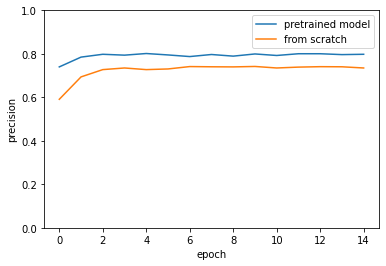

In [ ]:
#Visualize the accuracy
import matplotlib.pyplot as plt
figure = plt.figure()

axes = plt.gca()
axes.set_ylim(0,1)
plt.xlabel("epoch")
plt.ylabel( "precision")
plt.plot( pretrained_valid_acc, label="pretrained model")
plt.plot( from_scratch_valid_acc, label="from scratch" )
plt.legend()
plt.show()


In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
model = Model(ntokens, nhead, nhid, nlayers, 2, dropout).to(device)    
#print( model )
print( count_parameters( model))
print(ntokens)
#print("scratch model")
#print( from_scratch_valid_acc)
#print("pretrained model")
#print( pretrained_valid_acc)

+-------------------------------------------------------------+------------+
|                           Modules                           | Parameters |
+-------------------------------------------------------------+------------+
|                     base.encoder.weight                     |  10000200  |
|  base.transformer_encoder.layers.0.self_attn.in_proj_weight |   120000   |
|   base.transformer_encoder.layers.0.self_attn.in_proj_bias  |    600     |
| base.transformer_encoder.layers.0.self_attn.out_proj.weight |   40000    |
|  base.transformer_encoder.layers.0.self_attn.out_proj.bias  |    200     |
|       base.transformer_encoder.layers.0.linear1.weight      |   40000    |
|        base.transformer_encoder.layers.0.linear1.bias       |    200     |
|       base.transformer_encoder.layers.0.linear2.weight      |   40000    |
|        base.transformer_encoder.layers.0.linear2.bias       |    200     |
|        base.transformer_encoder.layers.0.norm1.weight       |    200     |

Positional encoding display

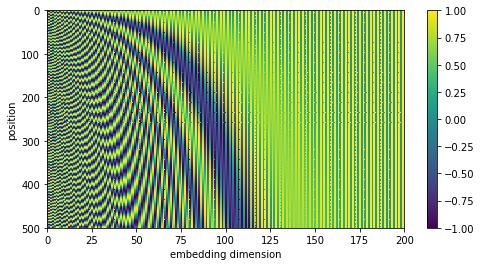

In [56]:
import matplotlib.pyplot as plt
max_len=500
pe = torch.zeros(max_len, nhid)
position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(
         torch.arange(0, nhid, 2).float() * (-math.log(10000.0) / nhid)
)
pe[:, 0::2] = torch.sin(position * div_term)
pe[:, 1::2] = torch.cos(position * div_term)

  
figure = plt.figure( figsize=(8,4))

axes = plt.gca()
axes.set_xlim(0,nhid)
axes.set_ylim(500,0)
plt.xlabel("embedding dimension")
plt.ylabel( "position")
plt.pcolormesh( pe[0:500,:], cmap='viridis')
#plt.plot( from_scratch_valid_acc, label="Positional Encoding" )
#plt.legend()
plt.colorbar()
plt.show()

